In [1]:
import cv2 as cv 
import os 

f = os.path.join('data','train','2','frame1.jpg') 
img_org = cv.imread(f) 

# Convert Image to Grayscale

In [2]:
img = cv.cvtColor(img_org,cv.COLOR_BGR2GRAY)

# Image Binarization

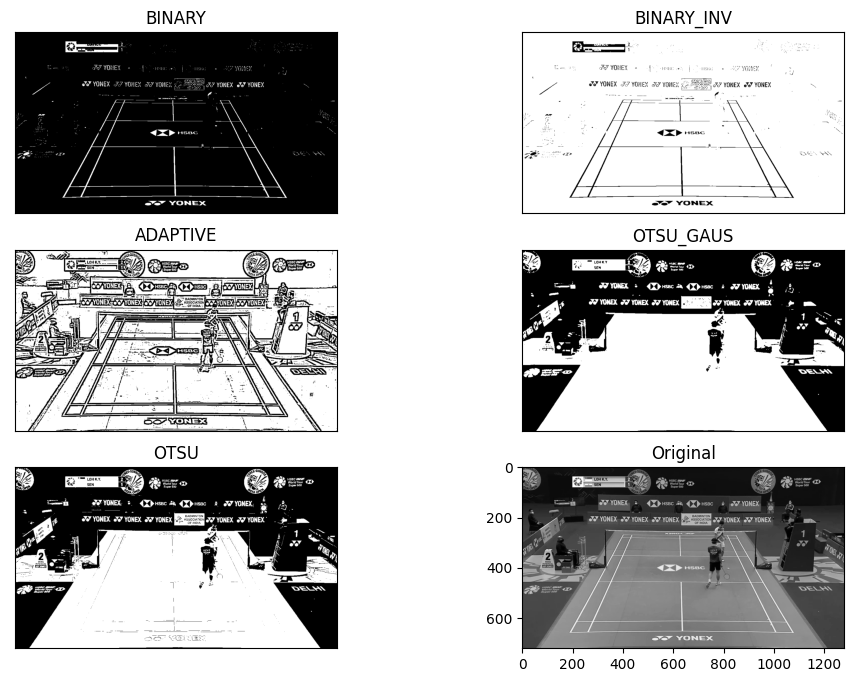

In [3]:
# Testing different Image Binarizations

from matplotlib import pyplot as plt

ret,th1 = cv.threshold(img,190,255,cv.THRESH_BINARY) 
ret,th2 = cv.threshold(img,190,255,cv.THRESH_BINARY_INV)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)  

blur = cv.GaussianBlur(img,(5,5),0)
ret,th4 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU) 

ret,th5 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU) 

images = [th1,th2,th3,th4, th5] 
titles = ['BINARY', 'BINARY_INV', 'ADAPTIVE', 'OTSU_GAUS', 'OTSU'] 


plt.figure(figsize=(12,8))
for i in range(5): 
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i],'gray') 
    plt.title(titles[i]) 
    plt.xticks([]),plt.yticks([])

plt.subplot(3,2,6)
plt.imshow(img, 'gray') 
plt.title('Original')
plt.show() 

# HoughLines

1) We use Canny Edge Detection to find the edges in the image (https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html) 
2) We apply Hough Transform. Info about it: (https://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm)

### Canny Edge Detection

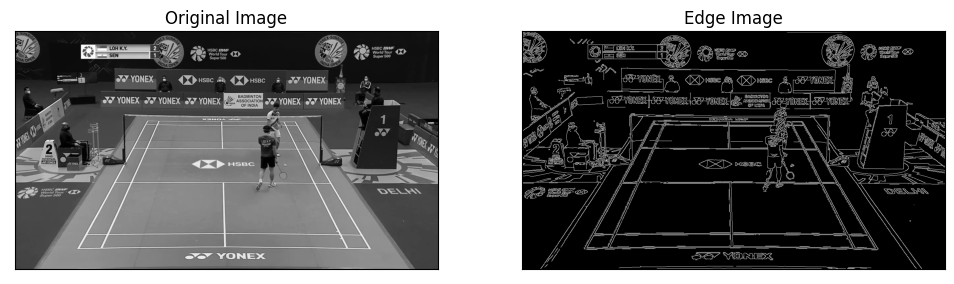

In [4]:
import numpy as np

# Visualizing edges

v = np.median(img)
sigma = 0.33 

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v)) 
upper = int(min(255, (1.0 + sigma) * v)) 
edges = cv.Canny(img, lower, upper, apertureSize=3) 

plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

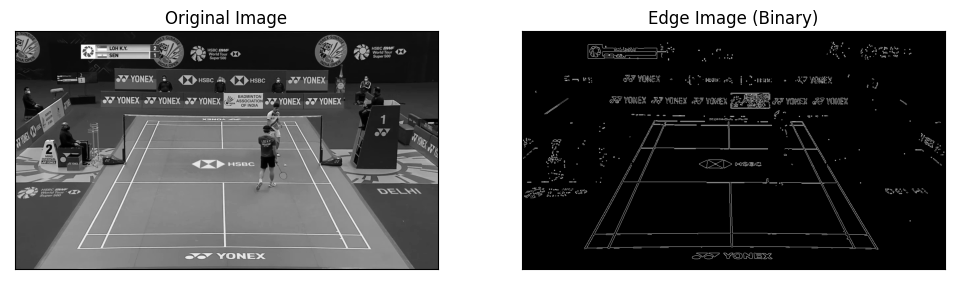

In [5]:
# Visualizing edges for binarized image 

v = np.median(img)
sigma = 0.33

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v)) 
upper = int(min(255, (1.0 + sigma) * v)) 
edges = cv.Canny(th1, lower, upper, apertureSize=3) 

plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image (Binary)'), plt.xticks([]), plt.yticks([])
plt.show()

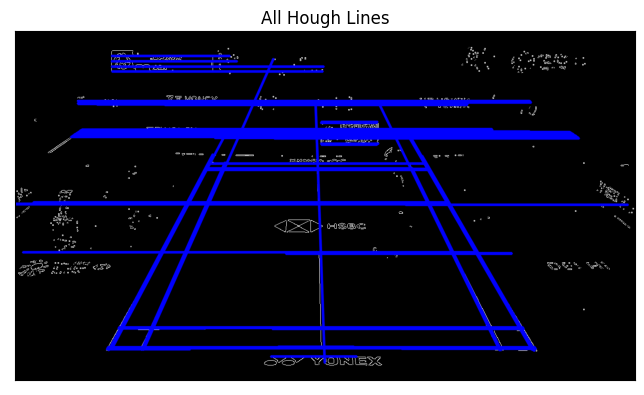

-1

In [6]:
# Probabilistic Hough Transform

import numpy as np
import math

# Copy edges to the images that will display the results in BGR
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

linesP = cv.HoughLinesP(edges, 1, np.pi / 90, 90, None, 10, 250)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
        
cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)
plt.figure(figsize=(8,6)) 
plt.imshow(cdstP, cmap='magma') 
plt.title('All Hough Lines'), plt.xticks([]), plt.yticks([])
plt.show() 

cv.waitKey()

# Extracting Horizontal and Vertical Lines

The idea is that horizontal lines will have roughly equal y-coordinates, while vertical will have similar x coordinates. 
However, because of the camera angles, the vertical lines of the court come out diagonal which is why the deltaX value in the code cell below has been set to 280 (Obtained through trial and error) 

In [7]:
def segment_lines(lines, deltaX, deltaY):
    h_lines = []
    v_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            if abs(y2-y1) < deltaY: # y-values are near; line is horizontal
                h_lines.append(line)
            elif abs(x2-x1) < deltaX: # x-values are near; line is vertical
                v_lines.append(line)
    return h_lines, v_lines

In [8]:
h_lines, v_lines = segment_lines(linesP, 280, 0.5) 
print('Total number of lines: ', linesP.shape[0]) 
print('Number of horizontal lines: ', len(h_lines)) 
print('Number of vertical lines: ', len(v_lines))  

Total number of lines:  74
Number of horizontal lines:  61
Number of vertical lines:  13


## Drawing all Vertical Lines

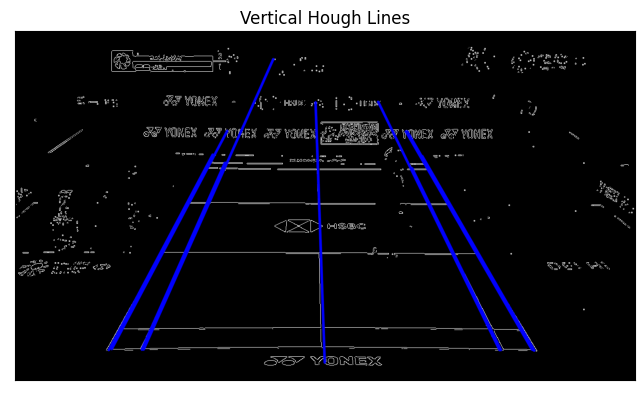

-1

In [9]:
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR) 

# Drawing Vertical Hough Lines on image 

for i in range(len(v_lines)): 
    l = v_lines[i][0] 
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
    
plt.figure(figsize=(8,6)) 
plt.imshow(cdstP, cmap='magma') 
plt.title('Vertical Hough Lines'), plt.xticks([]), plt.yticks([])
plt.show() 
    
cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)
cv.waitKey()

## Drawing all Horizontal Lines

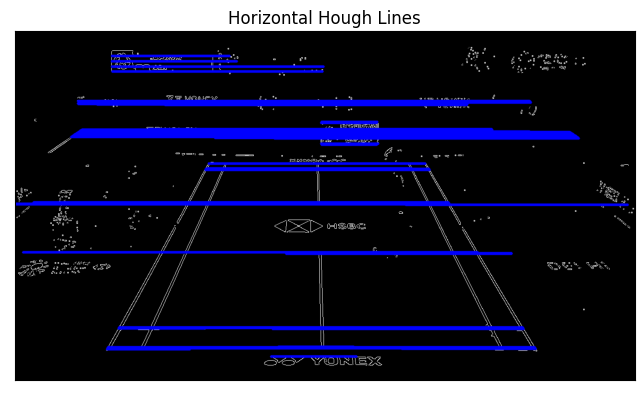

-1

In [10]:
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR) 

# Drawing Vertical Hough Lines on image 

for i in range(len(h_lines)): 
    l = h_lines[i][0] 
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
    
plt.figure(figsize=(8,6)) 
plt.imshow(cdstP, cmap='magma') 
plt.title('Horizontal Hough Lines'), plt.xticks([]), plt.yticks([])
plt.show() 
    
cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)
cv.waitKey()

In [11]:
import math

def filterLines(segments, minLength, maxLength): 
    result = []
    for segment in segments: 
        for x1,y1,x2,y2 in segment:  
            if  minLength < math.dist([x1,y1] , [x2,y2]) < maxLength: 
                # For Brute Testing
#                 print(x1,y1, '\t', x2,y2, '\t', math.dist([x1,y1] , [x2,y2]))
                result.append(segment) 
   
#     print('------------------------------')
    return result 
    

In [12]:
def getCourtLines(hsegments, vsegments): 
    h_result = [] 
    v_result = [] 
    for segment in hsegments: 
        for x1,y1,x2,y2 in segment:
            # Identified horizontal boundary lines using Brute Force
            if  (447.0 < math.dist([x1,y1] , [x2,y2]) < 449.0) or  (883.0 < math.dist([x1,y1] , [x2,y2]) < 885.0): 
                h_result.append(segment)
                
    for segment in vsegments: 
        for x1,y1,x2,y2 in segment:
            # Identified horizontal boundary lines using Brute Force
            if 450.0<math.dist([x1,y1] , [x2,y2]): 
                v_result.append(segment)   

    return h_result, v_result

Filtered Vertical Lines:  3
Filtered Horizontal Lines:  2


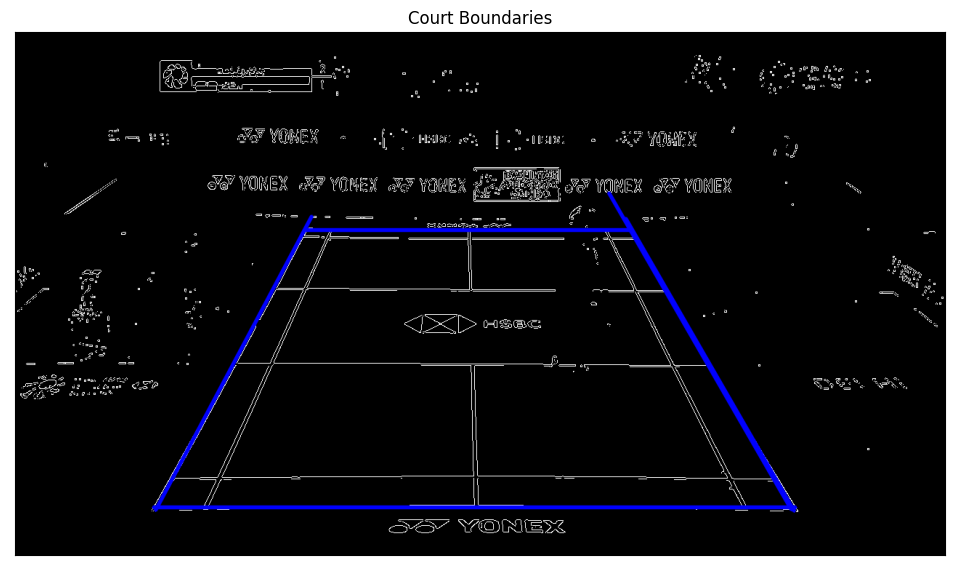

-1

In [13]:
cdstP = cv.cvtColor(edges, cv.COLOR_GRAY2BGR) 

filtered_h_lines, filtered_v_lines = getCourtLines(filterLines(h_lines,350, 900), filterLines(v_lines,430, 510))

print('Filtered Vertical Lines: ', len(filtered_v_lines))
print('Filtered Horizontal Lines: ', len(filtered_h_lines))

# Drawing Vertical Hough Lines on image 
for i in range(len(filtered_v_lines)): 
    l = filtered_v_lines[i][0] 
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)  
    
# Drawing Horizontal Hough Lines on image 
for i in range(len(filtered_h_lines)): 
    l = filtered_h_lines[i][0] 
    cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)  
    
plt.figure(figsize=(12,8)) 
plt.imshow(cdstP, cmap='Reds') 
plt.title('Court Boundaries'), plt.xticks([]), plt.yticks([])
plt.show() 
    
cv.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)

cv.waitKey()

# Finding Intersection of Boundary Hough Lines

Finding determinant of two line segments using the below formula can return the intersection point of those two lines. 

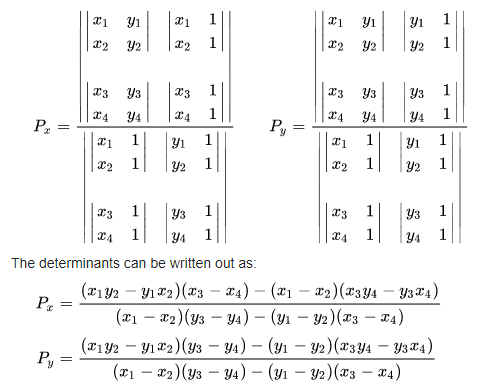 

Source: https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection#Given_two_points_on_each_line 

In [14]:
def find_intersection(line1, line2):
    # extract points
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]
    # compute determinant
    Px = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4))/  \
        ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
    Py = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4))/  \
        ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
    
    return Px, Py

So now if you loop through all your lines, you'll have intersection points from all your horizontal and vertical lines, but you have many lines, so you'll have many intersection points for the same corner of the box. (Even though there are exactly 2 lines here, we might have 2 overlapping lines for the same boundary line in other frames.) 

However, these are all in one vector, so not only do you need to average the points in each corner, you need to actually group them together, too.



In [15]:
def cluster_points(points, nclusters):
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, _, centers = cv.kmeans(points, nclusters, None, criteria, 10, cv.KMEANS_PP_CENTERS)
    return centers 

In [16]:
# find the line intersection points
Px = []
Py = []
for h_line in filtered_h_lines:
    for v_line in filtered_v_lines:
        px, py = find_intersection(h_line, v_line)
        Px.append(px)
        Py.append(py)

In [17]:
print(Px)
print(Py)

[195.12871287128712, 1069.1144278606964, 1066.2689655172414, 397.88861386138615, 849.2338308457712, 846.4275862068965]
[654.0, 654.0, 654.0, 273.0, 273.0, 273.0]


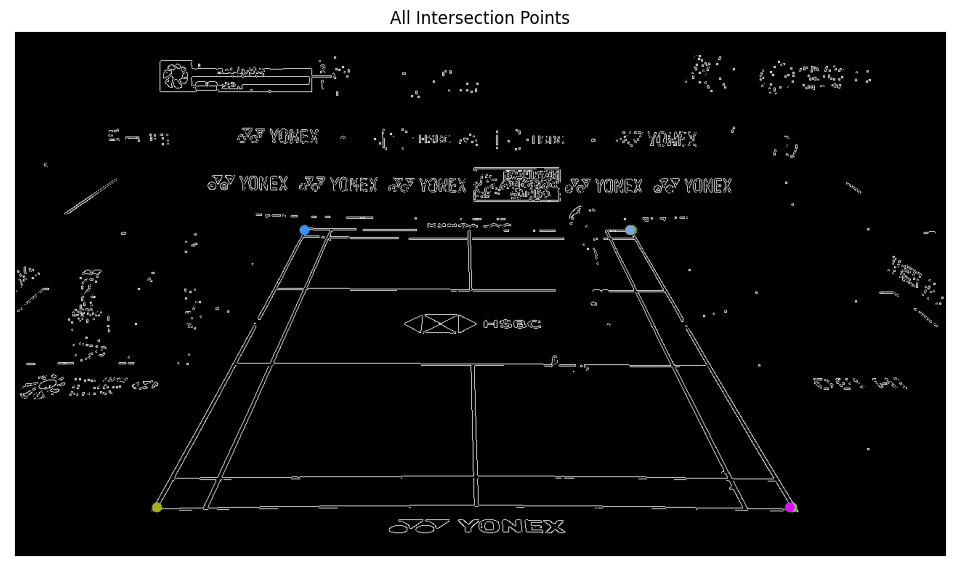

-1

In [18]:
# draw the intersection points (all of them) 

intersectsimg = edges.copy()
intersectsimg = cv.cvtColor(intersectsimg, cv.COLOR_GRAY2BGR) 

for cx, cy in zip(Px, Py):
    cx = np.round(cx).astype(int)
    cy = np.round(cy).astype(int)
    color = np.random.randint(0,255,3).tolist() # random colors
    cv.circle(intersectsimg, (cx, cy), radius=7, color=color, thickness=-1) # -1: filled circle

plt.figure(figsize=(12,8)) 
plt.imshow(intersectsimg, cmap='magma') 
plt.title('All Intersection Points'), plt.xticks([]), plt.yticks([])
plt.show() 
    
cv.imshow("Intersections", intersectsimg)
cv.waitKey(0)

In [19]:
# use clustering to find the centers of the data clusters

# P is the set of all the (x,y) of all the intersection points. This is done through column_stack
P = np.float32(np.column_stack((Px, Py)))
nclusters = 4
centers = cluster_points(P, nclusters)
print(centers)

[[ 847.8307   273.     ]
 [ 195.12871  654.     ]
 [1067.6917   654.     ]
 [ 397.8886   273.     ]]


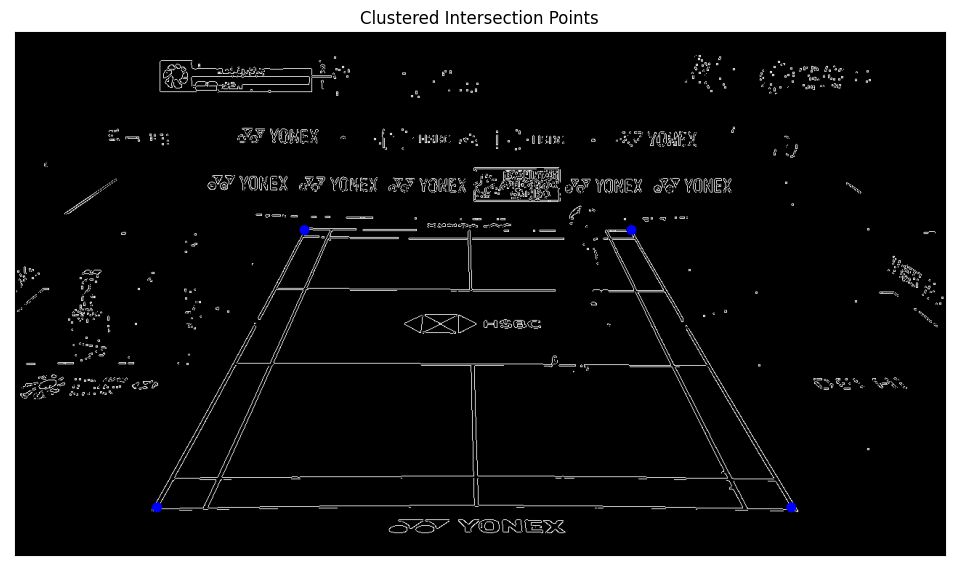

-1

In [20]:
# draw the center of the clusters

intersectsimg = edges.copy()
intersectsimg = cv.cvtColor(intersectsimg, cv.COLOR_GRAY2BGR)

for cx, cy in centers:
    cx = np.round(cx).astype(int)
    cy = np.round(cy).astype(int)
    cv.circle(intersectsimg, (cx, cy), radius=7, color=[0,0,255], thickness=-1) # -1: filled circle
    
plt.figure(figsize=(12,8)) 
plt.imshow(intersectsimg, cmap='magma') 
plt.title('Clustered Intersection Points'), plt.xticks([]), plt.yticks([])
plt.show() 

cv.imshow("Center of intersection clusters", intersectsimg)
cv.waitKey(0)